## Imports

In [51]:
import pandas as pd
import numpy as np
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data

In [2]:
sub = pd.read_csv('submission.csv')
sub.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [3]:
train = pd.read_csv('train.csv')
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [4]:
test = pd.read_csv('test.csv')
test.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17040 entries, 0 to 17039
Data columns (total 8 columns):
Id                17040 non-null int64
Province/State    7800 non-null object
Country/Region    17040 non-null object
Lat               17040 non-null float64
Long              17040 non-null float64
Date              17040 non-null object
ConfirmedCases    17040 non-null float64
Fatalities        17040 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 1.0+ MB


In [11]:
#% of data with confirmed case
len(train[train['ConfirmedCases']>0])/\
len(train)

0.38039906103286386

In [12]:
#% of data with fatalites
len(train[train['Fatalities']>0])/\
len(train)

0.13227699530516432

In [21]:
train.sort_values(by='Fatalities',ascending=False)[:1]

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
8039,12429,NaN,Italy,43.0,12.0,2020-03-21,53578.0,4825.0


In [31]:
X_train = train.drop(['ConfirmedCases','Fatalities','Id'],1)

In [34]:
X_train['Date'] = pd.to_datetime(X_train['Date'])

In [36]:
X_train = X_train.set_index(['Date'])

In [38]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [40]:
X_train_time = create_time_features(X_train)

In [42]:
X_train.drop('date',1,inplace=True)

In [43]:
X_train.dtypes

Province/State     object
Country/Region     object
Lat               float64
Long              float64
hour                int64
dayofweek           int64
quarter             int64
month               int64
year                int64
dayofyear           int64
dayofmonth          int64
weekofyear          int64
dtype: object

In [46]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Province/State'], prefix='ps')],axis=1)
X_train.drop(['Province/State'],axis=1, inplace=True)

KeyError: 'Province/State'

In [47]:
X_train.head()

,Country/Region,Lat,Long,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,...,ps_Virgin Islands,ps_Virginia,ps_Washington,ps_West Virginia,ps_Western Australia,ps_Wisconsin,ps_Wyoming,ps_Xinjiang,ps_Yunnan,ps_Zhejiang
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,Afghanistan,33.0,65.0,0,2,1,1,2020,22,22,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,Afghanistan,33.0,65.0,0,3,1,1,2020,23,23,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,Afghanistan,33.0,65.0,0,4,1,1,2020,24,24,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,Afghanistan,33.0,65.0,0,5,1,1,2020,25,25,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,Afghanistan,33.0,65.0,0,6,1,1,2020,26,26,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Country/Region'], prefix='cr')],axis=1)
X_train.drop(['Country/Region'],axis=1, inplace=True)

In [49]:
y_train = train['Fatalities']

In [52]:
reg = xgb.XGBRegressor(n_estimators=1000)

In [53]:
reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

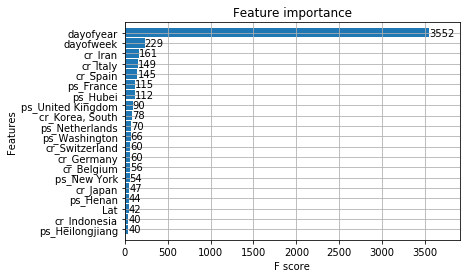

In [55]:
plot = plot_importance(reg, height=0.9, max_num_features=20)
plot

In [56]:
reg_pred = xgbmodel.predict(test)
reg_pred

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Province/State, Country/Region, Date